# Теория вероятностей и математическая статистика

Машинное обучение в цифровом продукте, ФКН ВШЭ

## Практическое задание 1: линейная регрессия

### Инфо

- Max балл за дз: 10

- Выполняется в группах по 2-3 человека!

- Присылает один человек от группы!

- Формат сдачи: решенная тетрадка .ipynb, .markdown или .pdf

- Дата выдачи: 07.11.2025

- Дедлайн: 22.11.2025 23:59

### Предисловие

Вот и подошло время первой домашки.

Она посвящена всему, что мы обсудили про линейную регрессию.



При оценивании большое внимание будет уделяться интерпретации (!), осознанию ограничений, качественно проведенным нужным тестам в нужное время, а также богатству инструментария, использованного при моделировании .

Вы можете использовать идеи, которые были подробно разобраны на лекциях и в семинарских тетрадках и пользоваться выводами и фактами оттуда без доказательств.

Можете глубже копнуть техники, которые лишь вскользь упоминались.

Можете использовать что-то, что в курсе не изучалось, однако лишь как дополнение к базовому анализу.
Использование методов, выходящих за рамки курса, не освобождает от необходимости хорошо понимать, что в них происходит и умения интерпретировать их результаты.

### Данные и постановка задачи

Представим, что нам поступил заказ из фитнес-индустрии.

Требуется сделать модель для расчета потраченных калорий за время выполнения упражнений.

![котя](https://i.pinimg.com/originals/16/dc/3a/16dc3ad1c7f1e529b6364ca3a9a0b77f.jpg)

При этом на основе модели важно уметь как делать точный расчет калорий для новых клиентов (для ведения тренировочных дневников), так и понимать причинно-следственную связь (как мне заниматься, чтобы тратить больше/меньше)

Данные доступны по ссылке: https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.api import linear_rainbow, het_goldfeldquandt
from statsmodels.tsa.stattools import acf
from linearmodels.iv import IV2SLS

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
ALPHA = 0.05 # зафиксируем глобальное значение уровня стат. значимости на значении 0.05

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Workout_Type                   973 non-null    object 
 9   Fat_Percentage                 973 non-null    float64
 10  Water_Intake (liters)          973 non-null    float64
 11  Workout_Frequency (days/week)  973 non-null    int64  
 12  Experience_Level               973 non-null    int

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,Strength,29.2,2.8,3,1,14.39
5,56,Female,58.0,1.68,168,156,74,1.59,HIIT,15.5,2.7,5,3,20.55
6,36,Male,70.3,1.72,174,169,73,1.49,Cardio,21.3,2.3,3,2,23.76
7,40,Female,69.7,1.51,189,141,64,1.27,Cardio,30.6,1.9,3,2,30.57
8,28,Male,121.7,1.94,185,127,52,1.03,Strength,28.9,2.6,4,2,32.34
9,28,Male,101.8,1.84,169,136,64,1.08,Cardio,29.7,2.7,3,1,30.07


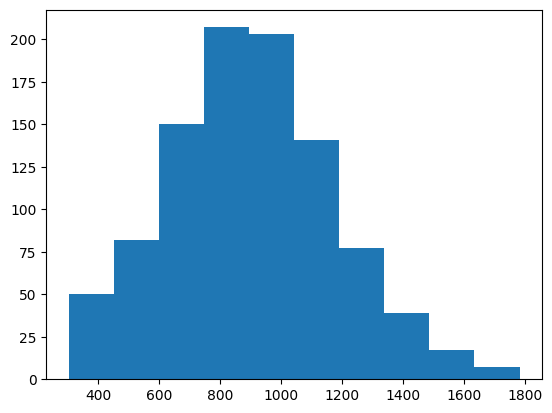

In [3]:
df = pd.read_csv("data/gym_dataset.csv", delimiter=";")

X = df.drop(['Calories_Burned'], axis=1)
y = df['Calories_Burned']

print(X.info())
display(X.head(10))

plt.hist(y)
plt.show()

### TASK 1: Базовая модель (0.3 балла)
Построим базовую модель линейной регрессии

Как известно, фитнес-браслеты умеют выдавать значение потраченных калорий на основе пульса

Сделаем модель "фитнес-браслета": по классике, учтем показатель пульса во время тренировки, ее длительность, а также рост, вес и возраст клиента

Проинтерпретируйте полученную модель:

- Значима ли она в целом? 
- Значимы ли коэффициенты?
- Какую долю дисперсии она объясняет?
- Соответствует ли построенная модель здравому смыслу? Почему?

In [4]:
X1 = X[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Session_Duration (hours)']]
X1 = sm.add_constant(X1)

X1.head(3)

,const,Age,Weight (kg),Height (m),Avg_BPM,Session_Duration (hours)
0,1.0,56,88.3,1.71,157,1.69
1,1.0,46,74.9,1.53,151,1.30
2,1.0,32,68.1,1.66,122,1.11


In [5]:
base_model = sm.OLS(y, X1).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     5583.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:55   Log-Likelihood:                -5184.3
No. Observations:                 973   AIC:                         1.038e+04
Df Residuals:                     967   BIC:                         1.041e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1099.4057     28.420    -38.685      0.000   -1155.177   -1043.634
Age                         -3.2231      0.132    -24.432      0.000      -3.482      -2.964
Weight (kg)                  0.9509      0.081     11.694      0.000       0.791       1.110
Height (m)                 148.1652     13.498     10.977      0.000     121.677     174.653
Avg_BPM                      6.2853      0.112     56.145      0.000       6.066       6.505
Session_Duration (hours)   716.6642      4.679    153.172      0.000     707.482     725.846
==============================================================================
Omnibus:                       37.540   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.816
Skew:                           0.389   Prob(JB):                     2.51e-11
Kurtosis:                       3.774   Cond. No.                     3.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
base_model.f_pvalue

0.0

👍

In [7]:
print(base_model.pvalues)

const                       1.427421e-198
Age                         4.653442e-103
Weight (kg)                  1.217788e-29
Height (m)                   1.675983e-26
Avg_BPM                     1.431952e-306
Session_Duration (hours)     0.000000e+00
dtype: float64


Доля объясненной дисперсии выше $96\%$, модель хорошо описывает зависимость целевой переменной от признаков.

Значимость модели в целом весомая. Малая величина $p\_value$ $F$-статистики опровергает гипотезу о равенстве всех коэффициентов нулю.

Все коэффичиенты по отдельности имеют очень маленькие $p\_value$ (по порядку меньше $10^{-25}$), что говорит об их значимости.

Обратим внимание на знаки коэффициентов.

Все они положительные, кроме коэффициента перед возрастом, что совпадает с интуицией: 

Больше пульс ($w_{Avg\_BPM} = 6.2853 \Rightarrow +6.29$ ккал за $1$ уд/мин) и дольшая сессия ($w_{Session\_Duration (hours)} = 716.6642 \Rightarrow +716.7$ ккал за час) естественно увеличивают затраты.

Больший вес/рост ($w_{Weight (kg)} = 0.9509, w_{Height (m)} = 148.1652$) тоже повышают калории, при этом возраст снижает ($w_{Age} = -3.2231 \Rightarrow −3.22$ за год жизни).

### TASK 2: Feature Engineering (1 балл)

Очевидно, что базовая модель неидеальна уже на уровне включаемых туда фич

- Преобразуйте показатели пульса (можно вдохновиться: https://www.polar.com/en/guide/heart-rate-zones)
- Подумайте, что еще из доступных фич с точки зрения здравого смысла и литературы имеет смысл включить и как
- Постройте новую модель, проведите необходимые тесты
- Сравните две модели, результаты какой Вам нравятся больше, почему?


- На данном этапе пока не думайте об условиях Г-М


### Начнем с выделения дамми-признаков, соответствующих зонам пульса.

In [8]:
df_fe = df.copy()

df_fe['HR_intensity'] = (df_fe['Avg_BPM'] - df_fe['Resting_BPM']) / (
    df_fe['Max_BPM'] - df_fe['Resting_BPM']
)
df_fe['HR_intensity'] = df_fe['HR_intensity'].clip(lower=0, upper=1.2)

df_fe['HR_zone'] = pd.cut(
    df_fe['HR_intensity'],
    bins=[0, 0.6, 0.7, 0.8, 0.9, 1.2],
    labels=['very_light', 'light', 'moderate', 'hard', 'max'],
    include_lowest=True
)

df_fe = pd.get_dummies(
    df_fe,
    columns=['Gender', 'HR_zone', 'Workout_Type'],
    drop_first=True,
    dtype=int,
)

df_fe.head()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),...,BMI,HR_intensity,Gender_Male,HR_zone_light,HR_zone_moderate,HR_zone_hard,HR_zone_max,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
0,56,88.3,1.71,180,157,60,1.69,1313,12.6,3.5,...,30.20,0.808333,1,0,0,1,0,0,0,1
1,46,74.9,1.53,179,151,66,1.30,883,33.9,2.1,...,32.00,0.752212,0,0,1,0,0,1,0,0
2,32,68.1,1.66,167,122,54,1.11,677,33.4,2.3,...,24.71,0.601770,0,1,0,0,0,0,0,0
3,25,53.2,1.70,190,164,56,0.59,532,28.8,2.1,...,18.41,0.805970,1,0,0,1,0,0,1,0
4,38,46.1,1.79,188,158,68,0.64,556,29.2,2.8,...,14.39,0.750000,1,0,1,0,0,0,1,0


Посмотрим, сколько примеров в каждом классе

In [9]:
f"HR_zone_very_light: {len(df_fe) - sum(df_fe.filter(like='HR_zone_').sum())}", df_fe.filter(like='HR_zone_').sum()

('HR_zone_very_light: 277',
 HR_zone_light       233
 HR_zone_moderate    221
 HR_zone_hard        139
 HR_zone_max         103
 dtype: int64)

Разброс есть, но не критичный: самая большая категория $277$, самая маленькая $103$ (соотношение $\sim 2.7:1$), можно использовать.
Также попробуем ввести дамми для обозначения вида спортивной деятельности.

In [10]:
zone_dummies = [c for c in df_fe.columns if c.startswith('HR_zone_')]
workout_dummies = [c for c in df_fe.columns if c.startswith('Workout_Type_')]

features_zone_model = [
    'Age',
    'Weight (kg)',
    'Height (m)',
    'Session_Duration (hours)',
] + zone_dummies + workout_dummies + [
    'HR_intensity'
]

X_zone = sm.add_constant(df_fe[features_zone_model])
model_zone = sm.OLS(y, X_zone).fit()
model_zone.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     1245.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:55   Log-Likelihood:                -5471.0
No. Observations:                 973   AIC:                         1.097e+04
Df Residuals:                     960   BIC:                         1.103e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -479.8543     45.188    -10.619      0.000    -568.533    -391.176
Age                         -3.2051      0.178    -17.984      0.000      -3.555      -2.855
Weight (kg)                  1.0532      0.110      9.572      0.000       0.837       1.269
Height (m)                 132.9915     18.242      7.291      0.000      97.193     168.790
Session_Duration (hours)   716.2040      6.331    113.125      0.000     703.780     728.628
HR_zone_light               11.1270      9.308      1.195      0.232      -7.140      29.394
HR_zone_moderate            57.4966     14.505      3.964      0.000      29.032      85.962
HR_zone_hard                49.8477     20.172      2.471      0.014      10.261      89.434
HR_zone_max                 45.3875     27.347      1.660      0.097      -8.279      99.054
Workout_Type_HIIT            2.7852      6.235      0.447      0.655      -9.451      15.022
Workout_Type_Strength        1.0683      5.983      0.179      0.858     -10.673      12.810
Workout_Type_Yoga           -1.6218      6.102     -0.266      0.790     -13.596      10.352
HR_intensity               392.1673     59.695      6.570      0.000     275.020     509.314
==============================================================================
Omnibus:                       21.588   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.034
Skew:                           0.267   Prob(JB):                     1.35e-06
Kurtosis:                       3.618   Cond. No.                     3.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Замена `Avg_BPM` на зоны вместе с непрерывным значением интенсивности пульса привела к падению качества, даже с учетом, что были добавлены и другие признаки. Следовательно идея с заменой абсолютного значения `Avg_BPM` на зоны `HR_zone-*` или относительную величину `HR_intensity` не дает преимущества. 

Кроме того, при наличии непрерывного признака вместе с зонами, стат. значимости вторых низкие (к примеру, $p\_value$ для `HR_zone_light` $ = 0.232$). Аналогично, не проходят проверку на стат. значимость (при $\alpha=0.05$) признаки, основанные на типе тренировки `Workout_Type_*` ($p\_value$ для `Workout_Type_HIIT`, `Workout_Type_Strength`, `Workout_Type_Yoga` равны $0.655, 0.858, 0.790$ соответственно).

Модель с зонами может быть более интерпретируема, но теряет в качестве $\Rightarrow$ будем использовать непрерывные, причем абсолютные значения для пульса.

Чтобы более справедливо убедиться в статистической незнасичмости добавленных признаков, дополнительно проведем $lr$-тест.

In [11]:
def test_hypothesis(p_value, alpha, H0='', H1='', test_name=''):
    print(f'\nИнтерпретация теста {test_name}:')
    
    if p_value < alpha:
        print(f'Гипотеза H0: "{H0}" отвергается в пользу альтернативной H1: "{H1}" на уровне значимости alpha={alpha}')
    else:
        print(f'Гипотеза H0: "{H0}" не отвергается на уровне значимости alpha={alpha} (p-value={p_value:.4f})')

In [12]:
extra_cols = zone_dummies + workout_dummies

X_full = sm.add_constant(df_fe[
        [
            'Age',
            'Weight (kg)',
            'Height (m)',
            'Avg_BPM', 
            'Session_Duration (hours)'
        ] + extra_cols
    ]
)
model_full = sm.OLS(y, X_full).fit()

lr_stat, lr_pvalue, lr_df = model_full.compare_lr_test(base_model)
print(f"LR stat={lr_stat:.2f}, df={int(lr_df)}, p-value={lr_pvalue:.3g}")

test_hypothesis(lr_pvalue, 
                ALPHA, 
                H0='Дополнительные переменные (zone_dummies + workout_dummies) не улучшают модель',
                H1='Дополнительные переменные (zone_dummies + workout_dummies) значимо улучшают модель',
                test_name='LR-тест')

LR stat=3.19, df=7, p-value=0.867

Интерпретация теста LR-тест:
Гипотеза H0: "Дополнительные переменные (zone_dummies + workout_dummies) не улучшают модель" не отвергается на уровне значимости alpha=0.05 (p-value=0.8671)


Как видно по высокому значению $p\_value = 0.867$, эти признаки действительно не улучшают модель.

### Попробуем добавить остальные фичи из датасета (за исключением гендера)

In [13]:
df_fe.columns

Index(['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
       'Water_Intake (liters)', 'Workout_Frequency (days/week)',
       'Experience_Level', 'BMI', 'HR_intensity', 'Gender_Male',
       'HR_zone_light', 'HR_zone_moderate', 'HR_zone_hard', 'HR_zone_max',
       'Workout_Type_HIIT', 'Workout_Type_Strength', 'Workout_Type_Yoga'],
      dtype='object')

In [14]:
features = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Fat_Percentage',
    'Water_Intake (liters)', 'Workout_Frequency (days/week)',
    'Experience_Level', 'BMI',
]

X = sm.add_constant(df_fe[features])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2803.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -5093.0
No. Observations:                 973   AIC:                         1.021e+04
Df Residuals:                     960   BIC:                         1.028e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1445.8230     97.402    -14.844      0.000   -1636.968   -1254.678
Age                              -3.3783      0.121    -27.843      0.000      -3.616      -3.140
Weight (kg)                      -2.4185      0.585     -4.134      0.000      -3.567      -1.270
Height (m)                      358.5908     52.119      6.880      0.000     256.310     460.872
Max_BPM                          -0.0106      0.128     -0.083      0.934      -0.262       0.241
Avg_BPM                           6.2601      0.103     60.975      0.000       6.059       6.462
Resting_BPM                       0.4961      0.201      2.468      0.014       0.102       0.891
Session_Duration (hours)        701.4006      6.774    103.547      0.000     688.107     714.694
Fat_Percentage                   -1.8955      0.377     -5.029      0.000      -2.635      -1.156
Water_Intake (liters)            25.9596      3.327      7.803      0.000      19.431      32.488
Workout_Frequency (days/week)     0.3242      2.946      0.110      0.912      -5.458       6.106
Experience_Level                -11.5610      4.567     -2.531      0.012     -20.524      -2.598
BMI                               9.2980      1.763      5.274      0.000       5.838      12.758
==============================================================================
Omnibus:                       12.299   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.079
Skew:                           0.124   Prob(JB):                     0.000196
Kurtosis:                       3.600   Cond. No.                     1.90e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`Workout_Frequency` и `Max_BPM` незначимы на увровне значимости $\alpha=0.05$ (p-value $>0.9$).

`Resting_BPM` и `Experience_Level` значимы при $\alpha=0.05$, но не значимы при $\alpha=0.01$ ($p\_value =  0.014 \text{ и } 0.012$ соответственно), так что их тоже уберем. 

Построим модель без данных признаков и убедимся в том, что $R^2$ не падает, а $aic$ практически не изменяется.

In [15]:
features = [
    'Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM',
    'Session_Duration (hours)', 'Fat_Percentage',
    'Water_Intake (liters)',
    'BMI',
]

X = sm.add_constant(df_fe[features])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     4147.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -5101.5
No. Observations:                 973   AIC:                         1.022e+04
Df Residuals:                     964   BIC:                         1.026e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1430.8527     93.483    -15.306      0.000   -1614.306   -1247.400
Age                         -3.3712      0.122    -27.633      0.000      -3.611      -3.132
Weight (kg)                 -2.3285      0.588     -3.960      0.000      -3.482      -1.175
Height (m)                 355.5343     52.403      6.785      0.000     252.698     458.371
Avg_BPM                      6.2834      0.103     61.000      0.000       6.081       6.486
Session_Duration (hours)   687.4034      5.436    126.453      0.000     676.736     698.071
Fat_Percentage              -1.4289      0.348     -4.110      0.000      -2.111      -0.747
Water_Intake (liters)       26.5247      3.343      7.933      0.000      19.964      33.086
BMI                          9.0404      1.772      5.101      0.000       5.562      12.519
==============================================================================
Omnibus:                       16.694   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.717
Skew:                           0.139   Prob(JB):                     2.60e-06
Kurtosis:                       3.747   Cond. No.                     1.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Действительно, $R^2$ не уменьшился ($0.972 \rightarrow 0.972$, как в случае стандартного $R^2$, так и в случае с $R^2_{Adj}$).

$Aic: 10210 \rightarrow 10220 \Rightarrow$ практически не изменился.

### Попробуем сконструировать нелинейные фичи

Добавим логарифм возраста. Интутивно кажется, что будет сильная корреляция, в случае ее возникновения будем с ней справляться потом, в следующих разделах.

In [16]:
df_fe['Log_Age'] = np.log(df_fe['Age'])

In [17]:
features = [
    'Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM',
    'Session_Duration (hours)', 'Fat_Percentage',
    'Water_Intake (liters)',
    'BMI',
    'Log_Age',
]

X = sm.add_constant(df_fe[features])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3763.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -5091.3
No. Observations:                 973   AIC:                         1.020e+04
Df Residuals:                     963   BIC:                         1.025e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1735.2635    114.510    -15.154      0.000   -1959.982   -1510.546
Age                         -6.9106      0.793     -8.713      0.000      -8.467      -5.354
Weight (kg)                 -2.2225      0.583     -3.815      0.000      -3.366      -1.079
Height (m)                 346.4811     51.923      6.673      0.000     244.587     448.375
Avg_BPM                      6.2997      0.102     61.731      0.000       6.099       6.500
Session_Duration (hours)   686.9621      5.383    127.615      0.000     676.398     697.526
Fat_Percentage              -1.4432      0.344     -4.192      0.000      -2.119      -0.768
Water_Intake (liters)       25.8680      3.313      7.807      0.000      19.366      32.370
BMI                          8.7956      1.756      5.010      0.000       5.350      12.241
Log_Age                    126.5354     28.026      4.515      0.000      71.537     181.534
==============================================================================
Omnibus:                       12.913   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               20.795
Skew:                           0.041   Prob(JB):                     3.05e-05
Kurtosis:                       3.711   Cond. No.                     1.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$Aic: 10220 \rightarrow 10200$ и $R^2: 0.972 \rightarrow 0.972$ практически не изменились. Так что в целом, можно добавить данный признак, так как по $p\_value$ ($< 0.001$) признак значимый на уровне значимости $\alpha=0.05$.

Попробуем также добавить скорость приема воды (л/час).

In [18]:
df_fe['Water_Intake (liters per hour)'] = (df_fe["Water_Intake (liters)"] / df_fe["Session_Duration (hours)"])

In [19]:
features = [
    'Age',
    'Log_Age',
    'Weight (kg)',
    'Height (m)',
    'BMI',
    'Avg_BPM',
    'Session_Duration (hours)',
    'Fat_Percentage',
    'Water_Intake (liters)',
    'Water_Intake (liters per hour)',
]

X = sm.add_constant(df_fe[features])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     3568.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -5066.0
No. Observations:                 973   AIC:                         1.015e+04
Df Residuals:                     962   BIC:                         1.021e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -1562.7003    114.206    -13.683      0.000   -1786.822   -1338.579
Age                               -6.9885      0.773     -9.037      0.000      -8.506      -5.471
Log_Age                          129.2499     27.324      4.730      0.000      75.628     182.872
Weight (kg)                       -2.0610      0.568     -3.626      0.000      -3.176      -0.945
Height (m)                       316.7265     50.789      6.236      0.000     217.057     416.396
BMI                                8.1314      1.714      4.744      0.000       4.768      11.495
Avg_BPM                            6.2947      0.099     63.270      0.000       6.099       6.490
Session_Duration (hours)         597.7862     13.516     44.230      0.000     571.263     624.310
Fat_Percentage                    -2.1508      0.350     -6.147      0.000      -2.837      -1.464
Water_Intake (liters)             60.5061      5.817     10.401      0.000      49.090      71.922
Water_Intake (liters per hour)   -37.2963      5.209     -7.160      0.000     -47.519     -27.074
==============================================================================
Omnibus:                       25.686   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.623
Skew:                           0.290   Prob(JB):                     5.00e-08
Kurtosis:                       3.703   Cond. No.                     1.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$R^2$ вырос на 0.002 $(0.972 \rightarrow 0.974)$. По $p\_value$ ($< 0.001$) признак значимый на уровне значимости $\alpha=0.05$.

А теперь добавим гендер.

In [20]:
features = [
    'Age',
    'Log_Age',
    'Weight (kg)',
    'Height (m)',
    'BMI',
    'Avg_BPM',
    'Session_Duration (hours)',
    'Fat_Percentage',
    'Water_Intake (liters)',
    'Water_Intake (liters per hour)',
    'Gender_Male',
]

X = sm.add_constant(df_fe[features])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     4296.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4932.0
No. Observations:                 973   AIC:                             9888.
Df Residuals:                     961   BIC:                             9947.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -1202.7992    101.675    -11.830      0.000   -1402.330   -1003.268
Age                               -6.7418      0.674     -9.998      0.000      -8.065      -5.419
Log_Age                          118.5808     23.829      4.976      0.000      71.818     165.344
Weight (kg)                       -1.0252      0.499     -2.054      0.040      -2.005      -0.046
Height (m)                       103.2368     45.935      2.247      0.025      13.093     193.380
BMI                                3.5083      1.518      2.312      0.021       0.530       6.486
Avg_BPM                            6.2652      0.087     72.221      0.000       6.095       6.435
Session_Duration (hours)         660.3677     12.316     53.619      0.000     636.199     684.537
Fat_Percentage                    -0.8805      0.314     -2.808      0.005      -1.496      -0.265
Water_Intake (liters)             19.3671      5.592      3.463      0.001       8.393      30.341
Water_Intake (liters per hour)   -21.2038      4.634     -4.576      0.000     -30.297     -12.110
Gender_Male                       78.2485      4.482     17.458      0.000      69.453      87.044
==============================================================================
Omnibus:                       60.324   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.921
Skew:                           0.414   Prob(JB):                     4.08e-26
Kurtosis:                       4.482   Cond. No.                     1.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Незначительно упала значимость некоторых признаков ($p\_value$ повысились), но не критично, на $5\%$ уровне все признаки остались значимыми.

При этом вырос $R^2: 0.974 \rightarrow 0.980$.

Попробуем следующую фичу: произведение среднего BPM на количества выпитой воды в час.

In [21]:
df_fe['Avg_BPM_Water_Intake_Speed'] = df_fe['Avg_BPM'] * df_fe['Water_Intake (liters per hour)']

In [22]:
features = [
    'Age',
    'Log_Age',
    'Weight (kg)',
    'Height (m)',
    'BMI',
    'Avg_BPM',
    'Session_Duration (hours)',
    'Fat_Percentage',
    'Water_Intake (liters)',
    'Water_Intake (liters per hour)',
    'Avg_BPM_Water_Intake_Speed',
    'Gender_Male',
]

X = sm.add_constant(df_fe[features])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     4699.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4847.1
No. Observations:                 973   AIC:                             9720.
Df Residuals:                     960   BIC:                             9784.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -1582.1419     97.359    -16.251      0.000   -1773.203   -1391.081
Age                               -6.7705      0.618    -10.950      0.000      -7.984      -5.557
Log_Age                          119.1113     21.850      5.451      0.000      76.232     161.991
Weight (kg)                       -0.7803      0.458     -1.704      0.089      -1.679       0.118
Height (m)                        78.5709     42.160      1.864      0.063      -4.165     161.306
BMI                                2.7934      1.393      2.006      0.045       0.061       5.526
Avg_BPM                            9.1011      0.224     40.584      0.000       8.661       9.541
Session_Duration (hours)         668.1561     11.308     59.088      0.000     645.965     690.347
Fat_Percentage                    -0.7870      0.288     -2.736      0.006      -1.351      -0.223
Water_Intake (liters)             16.9736      5.131      3.308      0.001       6.905      27.042
Water_Intake (liters per hour)   164.1085     14.345     11.440      0.000     135.958     192.259
Avg_BPM_Water_Intake_Speed        -1.2705      0.094    -13.526      0.000      -1.455      -1.086
Gender_Male                       80.0054      4.112     19.456      0.000      71.936      88.075
==============================================================================
Omnibus:                       50.711   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.273
Skew:                           0.409   Prob(JB):                     1.36e-18
Kurtosis:                       4.167   Cond. No.                     3.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Еще упала значимость некоторых параметров, часть из них потеряла стат. значимость на уровне $\alpha = 0.05$.

Разберемся с этой проблемой немного позже (после добавления еще некоторых признаков).

При этом в очередной раз подрос $R^2: 0.980 \rightarrow 0.983$.

### Посмотрим, поможет ли отделение роста, веса и bmi мужчин и женщин

In [23]:
df_fe["Male_Weight"] = df_fe["Gender_Male"] * df_fe["Weight (kg)"]
df_fe["Male_Height"] = df_fe["Gender_Male"] * df_fe["Height (m)"]
df_fe["Male_BMI"] = df_fe["Gender_Male"] * df_fe["BMI"]

In [24]:

features = [
    'Age',
    'Log_Age',
    'Weight (kg)',
    'Height (m)',
    'BMI',
    'Avg_BPM',
    'Session_Duration (hours)',
    'Fat_Percentage',
    'Water_Intake (liters)',
    'Water_Intake (liters per hour)',
    'Avg_BPM_Water_Intake_Speed',
    "Male_Weight",
    "Male_Height",
    "Male_BMI",
]

X = sm.add_constant(df_fe[features])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     4019.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4847.1
No. Observations:                 973   AIC:                             9724.
Df Residuals:                     958   BIC:                             9797.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -1544.9303    105.342    -14.666      0.000   -1751.658   -1338.203
Age                               -6.7709      0.619    -10.937      0.000      -7.986      -5.556
Log_Age                          119.1594     21.878      5.447      0.000      76.225     162.094
Weight (kg)                       -0.6500      0.736     -0.883      0.377      -2.094       0.794
Height (m)                        60.4080     50.496      1.196      0.232     -38.688     159.504
BMI                                2.1227      1.911      1.111      0.267      -1.628       5.873
Avg_BPM                            9.1018      0.225     40.493      0.000       8.661       9.543
Session_Duration (hours)         668.0080     11.322     58.999      0.000     645.789     690.228
Fat_Percentage                    -0.7894      0.288     -2.742      0.006      -1.354      -0.224
Water_Intake (liters)             16.9776      5.137      3.305      0.001       6.896      27.059
Water_Intake (liters per hour)   164.1930     14.367     11.429      0.000     135.999     192.387
Avg_BPM_Water_Intake_Speed        -1.2713      0.094    -13.514      0.000      -1.456      -1.087
Male_Weight                       -0.3491      0.434     -0.805      0.421      -1.200       0.502
Male_Height                       40.9753      8.032      5.102      0.000      25.213      56.737
Male_BMI                           1.4375      0.906      1.586      0.113      -0.341       3.216
==============================================================================
Omnibus:                       50.761   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.712
Skew:                           0.408   Prob(JB):                     1.09e-18
Kurtosis:                       4.173   Cond. No.                     3.85e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Похоже, что из-за сильной корреляции `роста`, `веса` и `BMI` у женщин и мужчин $p\_value$ соотвествующих признаков сильно выросли (к примеру, для веса $0.089 \rightarrow 0.377$)

Дополнительно немного возрос $Aic: 9720 \rightarrow 9724$ при неизменном $R^2 = 0.983$.

Итого: будем использовать модель без рассматривыемых признаков, так как они не дают существенных преимуществ.

Также добавим фичу, которая будет обозначать общее количество ударов сердца.

In [25]:
df_fe["Total_Heartbeat"] = df_fe["Avg_BPM"] * df_fe["Session_Duration (hours)"]

In [26]:
features = [
    'Age',
    'Log_Age',
    'Weight (kg)',
    'Height (m)',
    'BMI',
    'Avg_BPM',
    'Session_Duration (hours)',
    'Fat_Percentage',
    'Water_Intake (liters)',
    'Water_Intake (liters per hour)',
    'Avg_BPM_Water_Intake_Speed',
    'Gender_Male',
    'Total_Heartbeat',
]

X = sm.add_constant(df_fe[features])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     6143.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4679.7
No. Observations:                 973   AIC:                             9387.
Df Residuals:                     959   BIC:                             9456.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -87.5659    111.322     -0.787      0.432    -306.029     130.897
Age                               -6.9910      0.521    -13.420      0.000      -8.013      -5.969
Log_Age                          129.7366     18.412      7.046      0.000      93.604     165.869
Weight (kg)                       -0.3446      0.386     -0.892      0.373      -1.103       0.414
Height (m)                        31.6384     35.590      0.889      0.374     -38.204     101.481
BMI                                1.4526      1.175      1.236      0.217      -0.853       3.758
Avg_BPM                           -1.0266      0.544     -1.887      0.059      -2.094       0.041
Session_Duration (hours)        -102.8972     39.990     -2.573      0.010    -181.375     -24.419
Fat_Percentage                    -0.6819      0.242     -2.814      0.005      -1.157      -0.206
Water_Intake (liters)             15.9092      4.322      3.681      0.000       7.428      24.391
Water_Intake (liters per hour)   -48.7163     16.153     -3.016      0.003     -80.415     -17.017
Avg_BPM_Water_Intake_Speed         0.2228      0.109      2.041      0.042       0.009       0.437
Gender_Male                       80.2211      3.464     23.161      0.000      73.424      87.018
Total_Heartbeat                    5.4163      0.273     19.852      0.000       4.881       5.952
==============================================================================
Omnibus:                        3.767   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                4.358
Skew:                          -0.008   Prob(JB):                        0.113
Kurtosis:                       3.328   Cond. No.                     5.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$R^2$ вырос на $0.005$ ($ 0.983 \rightarrow 0.988$), при этом $p\_value$ некоторых признаков (`Weight (kg)`, `Height (m)`, `BMI`, `Session_Duration (hours)`) превысило уже $0.1$ (проблема!).

### Сравнение с моделью из Task 1

Сравним с базовой моделью из `task_1`, а потом попробуем убрать некоторые лишние признаки, в том числе те, которые содержались в базовой модели.

In [27]:
F_stat, p_val, df_diff = model.compare_f_test(base_model)
print(f"F-test: df_diff = {df_diff}, F = {F_stat}, p-value = {p_val}")

test_hypothesis(
    p_value=p_val,
    alpha=ALPHA,
    H0='Коэффициенты при дополнительных переменных одновременно равны нулю',
    H1='Хотя бы один коэффициент при дополнительных переменных не равен нулю',
    test_name='F-test'
)

F-test: df_diff = 8.0, F = 218.37753024704696, p-value = 4.7897597373581894e-210

Интерпретация теста F-test:
Гипотеза H0: "Коэффициенты при дополнительных переменных одновременно равны нулю" отвергается в пользу альтернативной H1: "Хотя бы один коэффициент при дополнительных переменных не равен нулю" на уровне значимости alpha=0.05


Коротко говоря, добавленные фичи статистически значимы, так как $p\_value \sim 1e-210$.

### Еще немного feature инженеринга 

Можно еще убрать `вес`, `рост` и `Avg_BPM`, чтобы избежать сильной корреляции с другими фичами, они незначимые на $5\%$ уровне.

In [28]:
features = [
    'Age',
    'Log_Age',
    'BMI',
    'Session_Duration (hours)',
    'Fat_Percentage',
    'Water_Intake (liters)',
    'Water_Intake (liters per hour)',
    'Avg_BPM_Water_Intake_Speed',
    'Gender_Male',
    'Total_Heartbeat',
]

X = sm.add_constant(df_fe[features])
featured_model = sm.OLS(y, X).fit()
featured_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     7973.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4681.9
No. Observations:                 973   AIC:                             9386.
Df Residuals:                     962   BIC:                             9440.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -178.8653     49.213     -3.634      0.000    -275.443     -82.288
Age                               -6.9907      0.521    -13.415      0.000      -8.013      -5.968
Log_Age                          129.5888     18.407      7.040      0.000      93.467     165.711
BMI                                0.4047      0.152      2.659      0.008       0.106       0.703
Session_Duration (hours)         -34.8497     16.149     -2.158      0.031     -66.541      -3.158
Fat_Percentage                    -0.6911      0.242     -2.850      0.004      -1.167      -0.215
Water_Intake (liters)             15.9521      4.322      3.691      0.000       7.470      24.434
Water_Intake (liters per hour)   -22.3418      8.393     -2.662      0.008     -38.812      -5.872
Avg_BPM_Water_Intake_Speed         0.0385      0.052      0.747      0.455      -0.063       0.140
Gender_Male                       80.9994      2.925     27.695      0.000      75.260      86.739
Total_Heartbeat                    4.9395      0.095     52.215      0.000       4.754       5.125
==============================================================================
Omnibus:                        4.300   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                5.047
Skew:                           0.033   Prob(JB):                       0.0802
Kurtosis:                       3.347   Cond. No.                     2.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$R^2: 0.988 \rightarrow 0.988$ (не изменился)

$Aic: 9387 \rightarrow 9386$ (практически не изменился)

Считаем удаление признаков `вес`, `рост` и `Avg_BPM` успешным.

Попробуем разделить суммарное колличество ударов за тренировочную сессию для мужчин и женщин.

In [29]:
df_fe["Heartbeat_Male"] = df_fe["Gender_Male"] * df_fe["Total_Heartbeat"]
df_fe["Heartbeat_Female"] = (1 - df_fe["Gender_Male"]) * df_fe["Total_Heartbeat"]

features = [
    'Age',
    'Log_Age',
    'BMI',
    'Session_Duration (hours)',
    'Fat_Percentage',
    'Water_Intake (liters)',
    'Water_Intake (liters per hour)',
    'Avg_BPM_Water_Intake_Speed',
    'Heartbeat_Male',
    'Heartbeat_Female',
]

X = sm.add_constant(df_fe[features])
featured_model = sm.OLS(y, X).fit()
featured_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     9493.
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4598.0
No. Observations:                 973   AIC:                             9218.
Df Residuals:                     962   BIC:                             9272.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -184.5504     45.148     -4.088      0.000    -273.150     -95.951
Age                               -6.8317      0.478    -14.288      0.000      -7.770      -5.893
Log_Age                          124.7418     16.889      7.386      0.000      91.598     157.885
BMI                                0.4077      0.139      2.931      0.003       0.135       0.681
Session_Duration (hours)          11.3427     15.095      0.751      0.453     -18.281      40.966
Fat_Percentage                    -0.2413      0.225     -1.073      0.283      -0.683       0.200
Water_Intake (liters)             -3.3446      4.191     -0.798      0.425     -11.569       4.880
Water_Intake (liters per hour)    -2.0059      7.783     -0.258      0.797     -17.279      13.267
Avg_BPM_Water_Intake_Speed         0.0257      0.047      0.543      0.587      -0.067       0.118
Heartbeat_Male                     5.1618      0.087     59.294      0.000       4.991       5.333
Heartbeat_Female                   4.6852      0.087     53.786      0.000       4.514       4.856
==============================================================================
Omnibus:                        6.869   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.643
Skew:                          -0.169   Prob(JB):                       0.0361
Kurtosis:                       2.778   Cond. No.                     2.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$R^2: 0.988 \rightarrow 0.99$, кроме того $p\_value$ у многих признаков значительно увеличилось до значений $0.2+$ (`Session_Duration (hours)`, `Fat_Percentage`, `Water_Intake (liters)`, `Water_Intake (liters per hour)`, `Avg_BPM_Water_Intake_Speed`), что говорит об их незначимости после добавления нового признака.

Удалим описанные выше признаки, снимем метрики.

In [30]:
features = [
    'Age',
    'Log_Age',
    'BMI',
    'Heartbeat_Male',
    'Heartbeat_Female',
]

X = sm.add_constant(df_fe[features])
well_featured_model = sm.OLS(y, X).fit()
well_featured_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.903e+04
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4599.4
No. Observations:                 973   AIC:                             9211.
Df Residuals:                     967   BIC:                             9240.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -192.9380     42.940     -4.493      0.000    -277.204    -108.672
Age                 -6.8410      0.477    -14.352      0.000      -7.776      -5.906
Log_Age            124.9575     16.837      7.422      0.000      91.916     157.999
BMI                  0.4073      0.139      2.935      0.003       0.135       0.680
Heartbeat_Male       5.2230      0.017    302.011      0.000       5.189       5.257
Heartbeat_Female     4.7483      0.017    271.874      0.000       4.714       4.783
==============================================================================
Omnibus:                        6.349   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.045
Skew:                          -0.154   Prob(JB):                       0.0487
Kurtosis:                       2.768   Cond. No.                     7.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$Aic: 9218 \rightarrow 9211$ немного упал (что хорошо)

Окончательно, будем использовать полученные признаки:
- 'Age'
- 'Log_Age'
- 'BMI'
- 'Heartbeat_Male'
- 'Heartbeat_Female'

Кстати, заметим, что даже достаточно небольшой набор признаков описывает $98.9\%$ дисперсии целевой переменной.

К примеру:

In [31]:
features = [
    'Age',
    'Heartbeat_Male',
    'Heartbeat_Female',
]

X = sm.add_constant(df_fe[features])
tiny_model = sm.OLS(y, X).fit()
tiny_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.988e+04
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4629.1
No. Observations:                 973   AIC:                             9266.
Df Residuals:                     969   BIC:                             9286.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              131.5408      4.345     30.276      0.000     123.015     140.067
Age                 -3.3478      0.074    -45.015      0.000      -3.494      -3.202
Heartbeat_Male       5.2300      0.018    294.697      0.000       5.195       5.265
Heartbeat_Female     4.7446      0.018    264.831      0.000       4.709       4.780
==============================================================================
Omnibus:                       10.329   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                7.966
Skew:                           0.122   Prob(JB):                       0.0186
Kurtosis:                       2.630   Cond. No.                         672.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2 = 0.989$, при всех $p\_value < 0.0001$

Что подтверждает ранее описанный факт.

### TASK 3: Нормальность остатков (0.5 балла)

Почему нормальность остатков не является условием Г-М?

Почему ее все-таки проверяют?

Проверьте нормальность остатков минимум четыремя способами, проинтерпретируйте результаты

Как считаете, нужно ли "лечить" модель?

- Почему нормальность остатков не является условием Г-М?
  
Это связано с тем, что теорема Гаусса-Маркова доказывает наилучшие свойства оценок (BLUE) без дополнительного предположения о нормальности остатков.

- Почему ее все-таки проверяют?
  
Проверка нормальности нужна для справедливости применения $t$ и $F$ тестов, так как в своих формулировках оба теста явно требуют нормальности распределений.

In [32]:
well_featured_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.903e+04
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4599.4
No. Observations:                 973   AIC:                             9211.
Df Residuals:                     967   BIC:                             9240.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -192.9380     42.940     -4.493      0.000    -277.204    -108.672
Age                 -6.8410      0.477    -14.352      0.000      -7.776      -5.906
Log_Age            124.9575     16.837      7.422      0.000      91.916     157.999
BMI                  0.4073      0.139      2.935      0.003       0.135       0.680
Heartbeat_Male       5.2230      0.017    302.011      0.000       5.189       5.257
Heartbeat_Female     4.7483      0.017    271.874      0.000       4.714       4.783
==============================================================================
Omnibus:                        6.349   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.045
Skew:                          -0.154   Prob(JB):                       0.0487
Kurtosis:                       2.768   Cond. No.                     7.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

В саммари видна $JB$ статистика $= 6.045$, а также $skewness = -0.154$ и $kurtosis = 2.768$.

На $5\%$ уровне значимости нормальность остатков по тесту Харке-Бера должна отвергаться (критическое значение статистики с распределением $\chi^2(2)$ для 5% уровня значимости $\approx$ $5.991$ и $6.045$ > $5.991$). 

Но кажется, что отклонение не очень сильное: $\text{skew} = -0.154$ (для нормального распредления $\text{skew} = 0$), $\text{kurt} \sim 2.8$ (для нормального распредления $\text{kurt} = 3$). 

Посмотрим на визуализацию остатков.

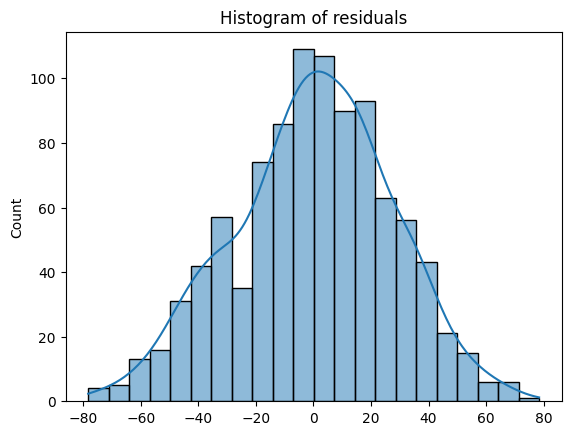

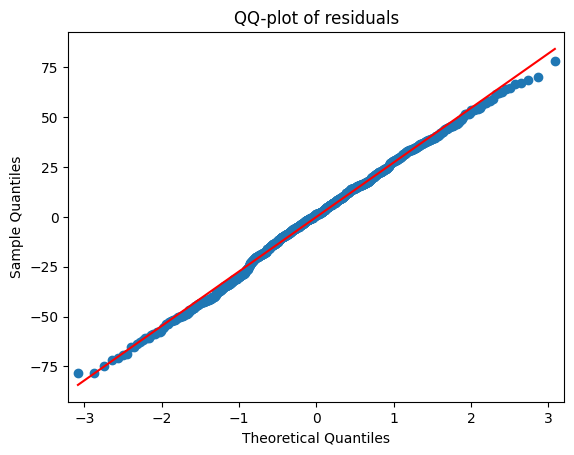

In [33]:
resid = well_featured_model.resid

sns.histplot(resid, kde=True)
plt.title('Histogram of residuals')
plt.show()

sm.qqplot(resid, line='s')
plt.title('QQ-plot of residuals')
plt.show()

Видно, что распределение близко к нормальному с незначительными отклонениями в правом хвосте (по QQ-plot).

Проведем несколько дополнительных тестов на нормальность.

In [34]:
resid_sample = resid.sample(973, random_state=42)
sh_stat, sh_p = stats.shapiro(resid_sample)
print(f'Shapiro-Wilk: stat = {sh_stat}, p = {sh_p}')

test_hypothesis(
    p_value=sh_p,
    alpha=ALPHA,
    H0='Остатки распределены нормально',
    H1='Остатки распределены не нормально',
    test_name='Shapiro-Wilk test'
)

Shapiro-Wilk: stat = 0.9959147572517395, p = 0.011318467557430267

Интерпретация теста Shapiro-Wilk test:
Гипотеза H0: "Остатки распределены нормально" отвергается в пользу альтернативной H1: "Остатки распределены не нормально" на уровне значимости alpha=0.05


In [35]:
resid_std = (resid - resid.mean()) / resid.std(ddof=1)
ks_stat, ks_p = stats.kstest(resid_std, 'norm')
print(f'KS test: stat = {ks_stat}, p = {ks_p}')

test_hypothesis(
    p_value=ks_p,
    alpha=ALPHA,
    H0='Остатки распределены нормально',
    H1='Остатки распределены не нормально',
    test_name='Kolmogorov-Smirnov test'
)

KS test: stat = 0.027833522458042714, p = 0.4303330229192822

Интерпретация теста Kolmogorov-Smirnov test:
Гипотеза H0: "Остатки распределены нормально" не отвергается на уровне значимости alpha=0.05 (p-value=0.4303)


По KS тесту на $5\%$ уровне нормальность не отвергается c $p\_value$ $\sim 0.487$. 

Но ассиметрия заметна на $JB$, также Shapiro-Wilk test дает $p\_value$ близкое к $0.01 \Rightarrow$ должна отвергаться.

Но будем считать, что на выборке из $973$ точек такие отклонения для $t$ и $F$ тестов не критичны (в силу ЦПТ).

### TASK 4: Условия Г-М
Проверьте каждое из условий Гаусса-Маркова для Вашей модели из второго задания

Общая схема проверки включает в себя:

- Визуальный анализ, если возможно
- 2-3 статистических теста с интерпретацией
- Починку сломавшегося условия или попытку это сделать
- Если не починилось, то обязательно нужно сказать, какие последствия это имеет и в каких постановках на практике это будет важно



#### TASK 4.1 Мультиколлинеарность (1 балл)

Проверьте наличие частичной линейной зависимости в матрице наблюдений минимум двумя способами

Стоит ли корректировать ее наличие? Объясните свою позицию

Если считаете нужным, избавьтесь от этой проблемы любым подходящим способом

### Посмотрим на VIF'ы и матрицу корреляций

In [36]:
features = [
    'Age',
    'Log_Age',
    'BMI',
    'Heartbeat_Male',
    'Heartbeat_Female',
]

X_mc = df_fe[features]
X_mc = sm.add_constant(X_mc)

vif = pd.DataFrame({
    'feature': X_mc.columns,
    'VIF': [variance_inflation_factor(X_mc.values, i)
            for i in range(X_mc.shape[1])]
})
vif

,feature,VIF
0,const,2386.688331
1,Age,43.594402
2,Log_Age,43.625872
3,BMI,1.104578
4,Heartbeat_Male,3.726020
5,Heartbeat_Female,3.729685


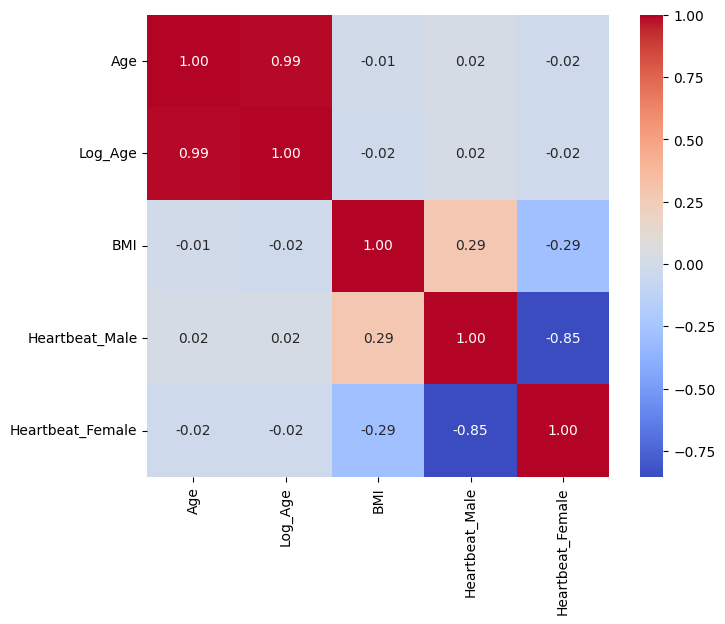

In [37]:
corr = df_fe[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.show()

Видна корреляция между столбцами с количеством ударов сердца для мужчин и для женщин (что логично, так как в любом месте, где в одной колонке стоит значение больше нуля, во второй обязан стоять 0). С этим можно ничего не делать, в целом, VIF для них не превышает 5. 

Также есть корреляция между индексом массы тела и колонками, выделенными для разных полов (что тоже логично, но не требует коррекции). 

Видна сильная корреляция между логарифмом возраста и возрастом, что также очень логично) Кроме того, VIF очень большой, более 40. 

Однако, если убрать возраст, или логарифм, качество немного упадет. Первый путь - ничего не делать с этим, глобально, оценки остануться несмещенными, но в силу такой сильной корреляции будут неустойчивыми, а также нельзя будет интерпретировать изменение целевой переменной через имзенении одного из признаков на 1, так как признаки между собой сильно скоррелированы и изменение одного из них влечет изменение другого. 

Попробуем для возраста оставить одну фичу, не потеряв при этом в качестве. Для этого добавим возраст в таком масштабе, который не ухудшит качества относительно модели с двумя параметрами - логарифмом Age и Age.

In [38]:
well_featured_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.903e+04
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4599.4
No. Observations:                 973   AIC:                             9211.
Df Residuals:                     967   BIC:                             9240.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -192.9380     42.940     -4.493      0.000    -277.204    -108.672
Age                 -6.8410      0.477    -14.352      0.000      -7.776      -5.906
Log_Age            124.9575     16.837      7.422      0.000      91.916     157.999
BMI                  0.4073      0.139      2.935      0.003       0.135       0.680
Heartbeat_Male       5.2230      0.017    302.011      0.000       5.189       5.257
Heartbeat_Female     4.7483      0.017    271.874      0.000       4.714       4.783
==============================================================================
Omnibus:                        6.349   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.045
Skew:                          -0.154   Prob(JB):                       0.0487
Kurtosis:                       2.768   Cond. No.                     7.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Добавим возраст в степени $7/4$.

In [39]:
df_fe['Age7div4'] = np.power(df_fe['Age'], 7/4)

In [40]:
features = [
    'BMI',
    'Heartbeat_Male',
    'Heartbeat_Female',
    'Age7div4',
]

X = sm.add_constant(df_fe[features])
clean_model = sm.OLS(y, X).fit()
clean_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Calories_Burned   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.306e+04
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                -4614.9
No. Observations:                 973   AIC:                             9240.
Df Residuals:                     968   BIC:                             9264.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               72.5811      5.073     14.308      0.000      62.626      82.536
BMI                  0.3913      0.141      2.785      0.005       0.116       0.667
Heartbeat_Male       5.2235      0.018    297.532      0.000       5.189       5.258
Heartbeat_Female     4.7476      0.018    267.663      0.000       4.713       4.782
Age7div4            -0.1250      0.003    -45.843      0.000      -0.130      -0.120
==============================================================================
Omnibus:                        6.511   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.105
Skew:                          -0.071   Prob(JB):                       0.0779
Kurtosis:                       2.675   Cond. No.                     4.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$R^2: 0.990 \rightarrow 0.990$ (не изменился). Вырос $Aic: 9211 \rightarrow 9240$, не не критично, зато удалось избавиться от сильной мультиколлинеарности и все VIF'ы должны придти в порядок.

Проверим это:

In [41]:
features = [
    'Age7div4',
    'BMI',
    'Heartbeat_Male',
    'Heartbeat_Female',
]

X_mc = df_fe[features]
X_mc = sm.add_constant(X_mc)

vif = pd.DataFrame({
    'feature': X_mc.columns,
    'VIF': [variance_inflation_factor(X_mc.values, i)
            for i in range(X_mc.shape[1])]
})
vif

,feature,VIF
0,const,32.295397
1,Age7div4,1.000533
2,BMI,1.098319
3,Heartbeat_Male,3.722929
4,Heartbeat_Female,3.729781


Итого: все VIF'ы < 5.

##### Регуляризация (1 балл)

Один из известных способов побороть частичную мультиколлинеарность - добавить регуляризацию

- В чем преимущества и недостатки ипользования такого подхода?

- Докажите, что добавление регуляризации (L1, L2, ElasticNet) дает смещенные оценки




- В чем преимущества и недостатки ипользования такого подхода?

Регуляризация уменьшает дисперсию оценок, борется с мультиколлинеарностью. L1 делает отбор признаков. Но оценки получаются смещенными, а интерпретация усложняется.

- Докажите, что добавление регуляризации (L1, L2, ElasticNet) дает смещенные оценки


1. Оценка МНК (OLS):

$\hat\beta_{OLS} = (X^T X)^{-1}X^T y$

Предполагая, что модель $y = X\beta + \varepsilon$ корректна и $\mathbb{E}[\varepsilon] = 0 \Rightarrow \mathbb{E}y = X \beta + 0$, получаем:

$\mathbb{E}[\hat\beta_{OLS}] = (X^T X)^{-1}X^T \mathbb{E}[y] = (X^T X)^{-1}X^T X\beta = \beta \Rightarrow$ OLS-оценка несмещена.

2. Ridge-оценка:

$\hat\beta_{ridge} = (X^\top X + \lambda I)^{-1}X^\top y$

Мат. ож.:
$\mathbb{E}[\hat\beta_{ridge}] = \mathbb{E}[(X^\top X + \lambda I)^{-1}X^\top y] = (X^\top X + \lambda I)^{-1}X^\top \mathbb{E}[y] = (X^\top X + \lambda I)^{-1}X^\top X\beta$

Очевидно: $(X^\top X + \lambda I)^{-1}X^\top X \neq I$ ($\forall \lambda \neq 0$).

Следовательно, $\mathbb{E}[\hat\beta_{ridge}] \neq \beta$.

3. Lasso-оценка:

Так как для Lasso не существует аналитического решения, то:

Предположим, что оценка Lasso является несмещенной: $\mathbb{E}[\hat\beta_{lasso}] = \beta$.

Основное свойств Lasso: для некоторых $j$, $\hat\beta_{lasso, j} = 0$ с положительной вероятностью.

Если $P(\hat\beta_{lasso, j} = 0) > 0$ и $\beta_j \neq 0$, то $\mathbb{E}[\hat\beta_{lasso, j}] < \beta_j$ (происходит сжатие к нулю). Следовательно, $\mathbb{E}[\hat\beta_{lasso}] \neq \beta$.

Таким образом, из свойства Lasso-регуляризации следует, что оценка будет смещенной для любого $\lambda > 0$.

4. ElasticNet

ElasticNet является линейной комбинацией L1 и L2-регуляризаций:

$\hat\beta_{elastic} = \arg\min_{\beta} ||y - X\beta||^2_2 + \lambda_1 || \beta ||_1 + \lambda_2 || \beta ||^2_2$

Если $\lambda_1 > 0$ и $\lambda_2 = 0 \Leftrightarrow$ Lasso (смещенная).

Если $\lambda_1 = 0$ и $\lambda_2 > 0 \Leftrightarrow$ Ridge (смещенная).

Поскольку при $\lambda_1 > 0$ или $\lambda_2 > 0$ оценка уже является смещенной, то и в общем случае, когда оба параметра положительны, оценка ElasticNet также будет смещенной. 

### Добавление регуляризации

Поскольку получилось сделать модель, в которой практически нет мультиколлинеарности, убрав лишние признаки, попробуем регуляризацию провести на модели с лучшим $R^2$, но с большим числом параметров, которая получилась до того, как убрали лишние фичи в пункте 2 (только age на age7div4 заменим для более корректного сравнения с полученной в результате отбора моделью).

In [42]:
from sklearn.linear_model import Ridge, Lasso

In [43]:
reg_features = [
    'Age7div4',
    'Log_Age',
    'BMI',
    'Session_Duration (hours)',
    'Fat_Percentage',
    'Water_Intake (liters)',
    'Water_Intake (liters per hour)',
    'Avg_BPM_Water_Intake_Speed',
    'Gender_Male',
    'Heartbeat_Male',
    'Heartbeat_Female',
]

X_reg = df_fe[reg_features]
y_reg = y

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reg)

X_ols = sm.add_constant(X_scaled)
ols_reg = sm.OLS(y_reg, X_ols).fit()

In [44]:
ridge = Ridge(alpha=10.0, fit_intercept=True, max_iter=10000)
ridge.fit(X_scaled, y_reg)

lasso = Lasso(alpha=2.0, fit_intercept=True, max_iter=10000)
lasso.fit(X_scaled, y_reg)

coef_df = pd.DataFrame({
    'feature': ['intercept'] + reg_features,
    'OLS': ols_reg.params.values,
    'Ridge': np.r_[ridge.intercept_, ridge.coef_],
    'Lasso': np.r_[lasso.intercept_, lasso.coef_],
})
coef_df

,feature,OLS,Ridge,Lasso
0,intercept,905.422405,905.422405,905.422405
1,Age7div4,-45.925766,-37.493595,-38.497099
2,Log_Age,5.220127,-2.634596,-0.000000
3,BMI,2.758392,2.468550,0.581763
4,Session_Duration (hours),4.605145,123.506269,41.916764
5,Fat_Percentage,-1.531708,-3.930802,-0.000000
6,Water_Intake (liters),-2.258892,0.196741,-0.000000
7,Water_Intake (liters per hour),-1.398282,-117.536594,-0.000000
8,Avg_BPM_Water_Intake_Speed,3.428140,119.003604,0.232458
9,Gender_Male,-1.501614,-1.445061,-0.000000


Ridge "сгладил" мультиколлинеарность: почти все коэффициенты по модулю уменьшились (к примеру, `Age7div4`: $-45.925766	\rightarrow -37.493595$, `Log_Age`: $5.220127 \rightarrow -2.634596$), но важные признаки `Heartbeat_Female`, `Heartbeat_Male` сохранили крупные значения ($255.86$ и $206.32$ соотв.).

L1 отобрал те же признаки, что и мы, только оставил еще `Session_Duration (hours)` и `Avg_BPM_Water_Intake_Speed` (однако, они не улучшают метрики, так что будем далее использовать модель без них).

#### TASK 4.2 Автокорреляция и гомоскедастичность (0.5 балла)

Проверьте наличие автокорреляции и гомоскедастичности несколькими известными Вам способами

Скорректируйте их наличие, если это возможно, любым известным Вам способом

### Автокорреляция

Временной или пространственной структуры у данных нет, так что автокорреляции неоткуда взяться.

### Гомоскедастичность

С помощью теста Уайта и Бройша-Пагана наличие гетероскедастичности.

Визуализация:

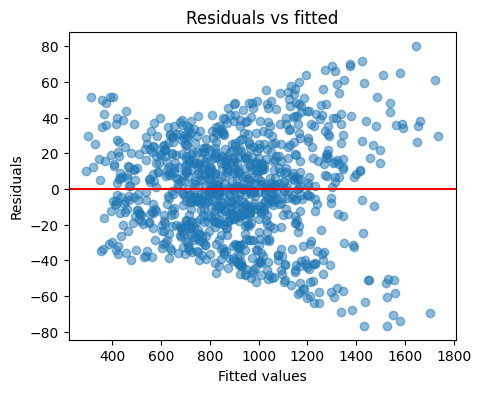

In [45]:
resid = clean_model.resid
fitted = clean_model.fittedvalues

plt.figure(figsize=(5, 4))
plt.scatter(fitted, resid, alpha=0.5)
plt.axhline(0, color="red")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs fitted")
plt.show()

Тесты:

In [46]:
bp_stat, bp_p, bp_f, bp_f_p = het_breuschpagan(resid, clean_model.model.exog)
print(f'Breusch–Pagan: stat = {bp_stat:.4f}, p-value = {bp_p}')

test_hypothesis(
    p_value=bp_p,
    alpha=ALPHA,
    H0='Остатки гомоскедастичны',
    H1='Остатки гетероскедастичны',
    test_name='Breusch-Pagan test'
)

Breusch–Pagan: stat = 179.8242, p-value = 8.133668550072404e-38

Интерпретация теста Breusch-Pagan test:
Гипотеза H0: "Остатки гомоскедастичны" отвергается в пользу альтернативной H1: "Остатки гетероскедастичны" на уровне значимости alpha=0.05


In [47]:
w_stat, w_p, w_f, w_f_p = het_white(resid, clean_model.model.exog)
print(f'White test: stat = {w_stat:.4f}, p-value = {w_p}')

test_hypothesis(
    p_value=w_p,
    alpha=ALPHA,
    H0='Остатки гомоскедастичны',
    H1='Остатки гетероскедастичны',
    test_name='White test на гетероскедастичность'
)

White test: stat = 413.0175, p-value = 3.971814834745319e-80

Интерпретация теста White test на гетероскедастичность:
Гипотеза H0: "Остатки гомоскедастичны" отвергается в пользу альтернативной H1: "Остатки гетероскедастичны" на уровне значимости alpha=0.05


Можно с уверенностью сказать, что гетероскедастичность присутствует: дисперсия ошибок меняется с уровнем факторов (из визуализации).

Дополнительно оба теста отвергают нулевую гипотезу и гомоскедастичности остатков.

Из-за этого оценки остаются несмещёнными и состоятельными, но $t$ и $F$-тесты могут давать неверные результаты. 

Можно попробовать трансформировать величины, чтоб уменьшить гетероскедастичность. Например, использовать логарифмические оси.

In [48]:
df_fe['log_calories']  = np.log(df_fe['Calories_Burned'])
df_fe['log_hb_male']   = np.log(np.clip(df_fe['Heartbeat_Male'], 1, np.inf))
df_fe['log_hb_female'] = np.log(np.clip(df_fe['Heartbeat_Female'], 1, np.inf))
df_fe['log_age7div4']  = np.log(df_fe['Age7div4'])
df_fe['log_bmi']       = np.log(df_fe['BMI'])

features = ['Age7div4', 'BMI', 'log_hb_male', 'log_hb_female']
X_log = sm.add_constant(df_fe[features])
log_model = sm.OLS(df_fe['log_calories'], X_log).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_calories   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 3.678e+04
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:56   Log-Likelihood:                 2166.1
No. Observations:                 973   AIC:                            -4322.
Df Residuals:                     968   BIC:                            -4298.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.7156      0.014    121.308      0.000       1.688       1.743
Age7div4         -0.0001   2.57e-06    -54.261      0.000      -0.000      -0.000
BMI               0.0003      0.000      2.224      0.026    3.48e-05       0.001
log_hb_male       1.0039      0.003    378.164      0.000       0.999       1.009
log_hb_female     0.9856      0.003    371.591      0.000       0.980       0.991
==============================================================================
Omnibus:                       45.136   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.374
Skew:                          -0.066   Prob(JB):                     6.21e-05
Kurtosis:                       2.321   Cond. No.                     1.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

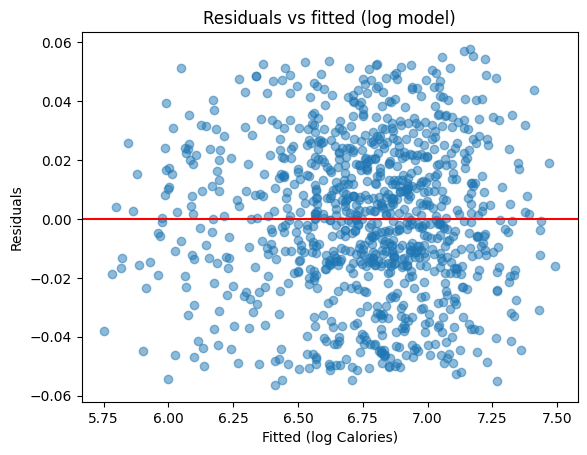

In [49]:
resid = log_model.resid
fitted = log_model.fittedvalues

plt.scatter(fitted, resid, alpha=0.5)
plt.axhline(0, color='red')
plt.xlabel('Fitted (log Calories)')
plt.ylabel('Residuals')
plt.title('Residuals vs fitted (log model)')
plt.show()

In [50]:
bp_stat, bp_p, bp_f, bp_f_p = het_breuschpagan(resid, log_model.model.exog)
print(f'Breusch–Pagan: stat = {bp_stat:.4f}, p-value = {bp_p}')

test_hypothesis(
    p_value=bp_p,
    alpha=ALPHA,
    H0='Остатки гомоскедастичны',
    H1='Остатки гетероскедастичны',
    test_name='Breusch-Pagan test'
)

Breusch–Pagan: stat = 26.4749, p-value = 2.5378988109529125e-05

Интерпретация теста Breusch-Pagan test:
Гипотеза H0: "Остатки гомоскедастичны" отвергается в пользу альтернативной H1: "Остатки гетероскедастичны" на уровне значимости alpha=0.05


In [51]:
w_stat, w_p, w_f, w_f_p = het_white(resid, log_model.model.exog)
print(f'White test: stat = {w_stat:.4f}, p-value = {w_p}')

test_hypothesis(
    p_value=w_p,
    alpha=ALPHA,
    H0='Остатки гомоскедастичны',
    H1='Остатки гетероскедастичны',
    test_name='White test на гетероскедастичность'
)

White test: stat = 365.3833, p-value = 4.4818007530311764e-70

Интерпретация теста White test на гетероскедастичность:
Гипотеза H0: "Остатки гомоскедастичны" отвергается в пользу альтернативной H1: "Остатки гетероскедастичны" на уровне значимости alpha=0.05


Модель обученная в лог. осях все равно обладает гетероскедастичностью, зато улучшилось качество $R^2: 0.990 \rightarrow 0.993$.

По прежнему, на любом разумном уровне доверия, гетероскедастичность присутствует, но чуть меньше, чем у модели на линейных фичах.

#### TASK 4.3 Эндогенность

##### Формальная проверка (0.5 баллов)

Формально проверьте наличие эндогенности любым известным Вам способом

Несмотря на результаты тестов и визуализации, как Вы считаете, есть ли эндогенность в построенной модели?

#### Формальная проверка эндогенности

Применим RESET-тест Рамсея

In [52]:
from statsmodels.stats.outliers_influence import reset_ramsey

predicted_log = log_model.predict(X_log)

df_fe['predicted_log_sq'] = predicted_log ** 2
df_fe['predicted_log_cube'] = predicted_log ** 3

reset_result = reset_ramsey(log_model, degree=3)


print(f'Ramsey RESET Test: p-value = {reset_result.pvalue}')

test_hypothesis(
    p_value=reset_result.pvalue,
    alpha=ALPHA,
    H0='Отсутствует проблема эндогенности',
    H1='Возможна проблема эндогенности',
    test_name='Ramsey RESET test'
)

Ramsey RESET Test: p-value = 0.5328172540767915

Интерпретация теста Ramsey RESET test:
Гипотеза H0: "Отсутствует проблема эндогенности" не отвергается на уровне значимости alpha=0.05 (p-value=0.5328)


$p\_value = 0.5328 > 0.05 \Rightarrow$ нулевая гипотеза не отвергается.

RESET test не выявил статистически значимых признаков пропущенных нелинейных эффектов или проблем спецификации модели. Это указывает на то, что модель в целом адекватна.

Несмотря на положительный результат RESET test, следующие переменные требуют особого внимания:

1. `Total_Heartbeat`: Может коррелировать с неучтенными факторами - интенсивность тренировки, эмоциональное состояние, уровень стресса, качество сна.

2. `BMI`: Может зависеть от неучтенных факторов - метаболизма, генетики, среднего уровеня активности.

Для окончательных выводов стоит провести тест Хаусмана для прямого тестирования эндогенности (проведем его далее).

##### Эндогенные переменные (1 балл)

Зачастую на первый взгляд не так-то просто сказать, какие именно переменные пропущены, и какие вследствие этого переменные в модели становятся эндогенными.

Именно поэтому эконометрические исследования славятся очень подробными обзорами литературы и погружением в научный контекст.

Попробуем немного погрузиться в спортивную медицину.

Изучите предложенные статьи:

- https://www.ideafit.com/wp-content/uploads/files/_archive/062005_calculatin.pdf
- https://pmc.ncbi.nlm.nih.gov/articles/PMC5663671/
- https://www.researchgate.net/publication/9025532_Effect_of_Exercise_Intensity_Duration_and_Mode_on_Post-Exercise_Oxygen_Consumption


На основе прочитанного, выдвините свое предположение, какие переменные пропущены и какие переменные в модели становятся эндогенными (их может быть больше одной)

На основе анализа представленных статей, можно предположить следующее:

Возможные пропущенные переменные:
- Уровень VO2max или уровень сарколипина (SLN) в мышцах
- Уровень глюкозы в крови, концентрация кальция в мышцах

Возможные эндогенные переменные (как предполагалось ранее):

1. `Total_Heartbeat`: Может коррелировать с неучтенными факторами - интенсивность тренировки, эмоциональное состояние, уровень стресса, качество сна.

2. `BMI`: Может зависеть от неучтенных факторов - метаболизма, генетики, среднего уровеня активности.

##### Инструменты (1 балл)

Сконструируйте инструменты на основе имеющихся данных, если это возможно

Оцените регрессию с инструментами двухшаговым МНК

#### Тест Хаусмана на эндогенность

In [53]:
from scipy.stats import chi2

def hausman_test(iv_results, ols_results, params_to_test=['BMI', 'log_hb_male', 'log_hb_female']):

    diff_coefs = (iv_results.params[params_to_test] - ols_results.params[params_to_test])

    cov_diff = (iv_results.cov - ols_results.cov).loc[params_to_test, params_to_test]
            
    H = diff_coefs @ np.linalg.inv(cov_diff) @ diff_coefs
    
    p_value = 1 - chi2.cdf(H, len(diff_coefs))
    
    return H, p_value

In [54]:
from linearmodels import IV2SLS, OLS
from linearmodels.iv.results import compare

formula_ols = 'log_calories ~ 1 + Age7div4 + BMI + log_hb_male + log_hb_female'
ols_model_lm = OLS.from_formula(formula_ols, data=df_fe).fit()

formula_iv_log = 'log_calories ~ 1 + Age7div4 + [BMI + log_hb_male + log_hb_female ~ Resting_BPM + Max_BPM + Log_Age + Gender_Male + Fat_Percentage]'
iv_model_log = IV2SLS.from_formula(formula_iv_log, data=df_fe).fit()

results_log = compare({'OLS': ols_model_lm, 'IV': iv_model_log})
print("Сравнение моделей:")
print(results_log)

H_manual, p_value_manual = hausman_test(iv_model_log, ols_model_lm)
print(f'Ramsey RESET Test: stat = {H_manual:.4f} p-value = {reset_result.pvalue:.4f}')


test_hypothesis(
    p_value=p_value_manual,
    alpha=ALPHA,
    H0='Все объясняющие переменные экзогенны (OLS оценки состоятельны)',
    H1='Присутствует эндогенность среди объясняющих переменных (IV оценки предпочтительнее)',
    test_name='Hausman test'
)

Сравнение моделей:
                   Model Comparison                   
                                  OLS               IV
------------------------------------------------------
Dep. Variable            log_calories     log_calories
Estimator                         OLS          IV-2SLS
No. Observations                  973              973
Cov. Est.                      robust           robust
R-squared                      0.9935           0.9932
Adj. R-squared                 0.9934           0.9932
F-statistic                 1.546e+05        4.655e+04
P-value (F-stat)               0.0000           0.0000
==================     ==============   ==============
Intercept                      1.7156           1.7185
                             (122.29)         (38.472)
Age7div4                      -0.0001          -0.0001
                            (-83.942)        (-78.013)
BMI                            0.0003          -0.0005
                             (2.2246)        (

Интерпретация результатов теста Хаусмана:

Проверял гипотезу об экзогенности трех переменных: `BMI`, `log_hb_male` и `log_hb_female`. 

Для проверки использовались инструменты: `Resting_BPM`, `Max_BPM`, `Log_Age`, `Gender_Male` и `Fat_Percentage`. 

Результаты теста ($H = 2.0472$, $p\_value = 0.7271$) показывают, что нет оснований отвергать нулевую гипотезу об экзогенности рассматриваемых переменных. 

##### Польза инструментов (1 балл)

Что лучше, оценить регрессию, используя слабые инструменты?

Или не используя их вовсе?

Докажите свою мысль

В силу проведенного теста проблема эндогенности для указанных переменных статистически не подтверждается $ \Rightarrow$ оценки обычного МНК являются состоятельными. Также у модели с использованием инструментов падает $R^2: 0.9935 \rightarrow 0.9932$ относительно базовой модели. 

Основываясь на этих двух фактах, будем использовать обычную МНК модель, так как она более эффективна.

#### TASK 4.4 Нулевое мат ожидание ошибки (0.5 балла)

После всех проделанных операций проверьте равенство мат. ожидания ошибок нулю

Насколько "страшны" последствия невыполнения такого условия?

In [55]:
residuals = log_model.resid

t_statistic, p_value = stats.ttest_1samp(residuals, popmean=0)

print(f'Ramsey RESET Test: stat = {t_statistic:.4f} p-value = {p_value:.4f}')

print(f"Mean residuals: {residuals.mean():.4f}")
print(f"Std residuals: {residuals.std():.4f}")

test_hypothesis(
    p_value=p_value,
    alpha=ALPHA,
    H0='Математическое ожидание остатков равно нулю',
    H1='Математическое ожидание остатков не равно нулю',
    test_name='t-test на нулевое среднее остатков'
)

Ramsey RESET Test: stat = 0.0000 p-value = 1.0000
Mean residuals: 0.0000
Std residuals: 0.0261

Интерпретация теста t-test на нулевое среднее остатков:
Гипотеза H0: "Математическое ожидание остатков равно нулю" не отвергается на уровне значимости alpha=0.05 (p-value=1.0000)


- Насколько "страшны" последствия невыполнения такого условия?

Такое нарушение является критическим:
- Модель систематически завышает или занижает прогнозы - все предсказания оказываются смещенными в одну сторону. Из-за этого модель теряет всякую предсказательную ценность
- Модель теряет интерпретируемость. Свободный член перестает иметь смысл, нарушается логика влияния предикторов на целевую переменную. 

Но так как мы используем OLS с константой это условие выполняется автоматически, что и подтверждается примененным $t$-тестом.

### TASK 5 Бинарная переменная (0.7 балла)

Есть идея о том, что мужчины и женщины расходуют разное кол-во калорий при выполнении упражнений одинаковой интенсивности

Как Вы считаете, есть ли смысл строить две отдельные модели для мужчин и женщин?

Проведите формальный тест Чоу на включение дамми-переменной 

- Вы можете описать суть теста Чоу и взять выкладки из статпакета, либо написать функцию для расчета

In [56]:
from scipy.stats import f

def chow_test(X, y, group_var, alpha=0.05):
    X1, y1 = X[group_var == 1], y[group_var == 1]
    X2, y2 = X[group_var == 0], y[group_var == 0]
    
    model_together = sm.OLS(y, X).fit()
    SSR_together = model_together.ssr
    N_pooled = len(y)
    k = X.shape[1]
    
    model_man = sm.OLS(y1, X1).fit()
    SSR1 = model_man.ssr
    n1 = len(y1)
    
    model_wooman = sm.OLS(y2, X2).fit()
    SSR2 = model_wooman.ssr
    n2 = len(y2)
    
    SSR_12 = SSR1 + SSR2

    chow_statistic = ((SSR_together - SSR_12) / k) / ( SSR_12 / (n1 + n2 - 2 * k))
    
    p_value = 1 - f.cdf(chow_statistic, k, n1 + n2 - 2 * k)
    
    critical_value = f.ppf(1 - alpha, k, n1 + n2 - 2 * k)
    
    return chow_statistic, p_value

In [57]:
df_fe['log_hb'] = np.log(np.clip(df_fe['Total_Heartbeat'], 1, np.inf))

In [58]:
features = ['Age7div4', 'BMI', 'log_hb']

group_var = df_fe['Gender_Male'] 
chow_statistic, p_value = chow_test(df_fe[features].values, df_fe['log_calories'].values, group_var.values, alpha=ALPHA)

print(f"Chow-статистика: {chow_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

test_hypothesis(
    p_value=p_value,
    alpha=ALPHA,
    H0='Одна модель для мужчин и женщин адекватна',
    H1='Нужны отдельные модели для мужчин и женщин',
    test_name='Chow test'
)

Chow-статистика: 45.8172
P-value: 0.0000

Интерпретация теста Chow test:
Гипотеза H0: "Одна модель для мужчин и женщин адекватна" отвергается в пользу альтернативной H1: "Нужны отдельные модели для мужчин и женщин" на уровне значимости alpha=0.05


На уровне значимости $\alpha=0.05$ нулевая гипотеза об адекватности одной модели отвергается, следовательно в очередной раз доказана необходимость использования переменных разделенных по полу.

### TASK 6 Интерпретация (1 балл)

- Проинтерпретируйте коэффициенты в финальной модели

- Оцените важность признаков в модели любыми известными способами

- Проговорите, какие у нее недостатки и для каких задач ее корректно использовать

- Если бы мы говорили о бизнес-постановке, как бы Вы сформировали тестовую выборку для модели?

- Каков был бы критерий качества для Вас?

In [59]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_calories   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 3.678e+04
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:06:57   Log-Likelihood:                 2166.1
No. Observations:                 973   AIC:                            -4322.
Df Residuals:                     968   BIC:                            -4298.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.7156      0.014    121.308      0.000       1.688       1.743
Age7div4         -0.0001   2.57e-06    -54.261      0.000      -0.000      -0.000
BMI               0.0003      0.000      2.224      0.026    3.48e-05       0.001
log_hb_male       1.0039      0.003    378.164      0.000       0.999       1.009
log_hb_female     0.9856      0.003    371.591      0.000       0.980       0.991
==============================================================================
Omnibus:                       45.136   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.374
Skew:                          -0.066   Prob(JB):                     6.21e-05
Kurtosis:                       2.321   Cond. No.                     1.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Интерпретация коэффициентов в финальной модели (все статистически значимы на урвоне $\alpha=0.05$)

Помним, что в данной модели отсуствует мультиколлинеарность. Это означает, что коэффициенты модели стабильны и независимы друг от друга.

Модель предсказывает логарифм калорий (`log_calories`).

- `const` (1.7156): Базовый уровень логарифма калорий, содержательной интерпретации не имеет, так как соответствует условию, когда пульс равен нулю, BMI и возраст равны нулю.

- `Age7div4` (-0.0001): 
При увеличении возраста и при фиксированных значениях пульса и BMI, логарифм сожженных калорий снижается. Это логично: метаболизм с возрастом замедляется.

- `BMI` (0.0003):
При увеличении индекса массы тела (BMI) на 1 единицу и при фиксированных возрасте и пульсе, логарифм калорий увеличивается на 0.0003. В исходной шкале это увеличение калорий в среднем на $0.03\%$. Это логично: для поддержания и перемещения "большего" тела требуется больше энергии.

- `log_hb_male` (1.0039) и `log_hb_female` (0.9856) - ключевые факторы.

- - Интерпретация для мужчин: При увеличении суммарного количества сердечных ударов у мужчин на $1\%$ и при фиксированных возрасте и BMI, количество сожженных калорий увеличивается в среднем на $1.0039\%$.

- - Интерпретация для женщин: При увеличении суммарного количества сердечных ударов у женщин на $1\%$ и при фиксированных возрасте и BMI, количество сожженных калорий увеличивается в среднем на $0.9856\%$.

Итог: коэффициенты модели явно говорят о том, что суммарного количества сердечных ударов - главный фактор расхода калорий. С возрастом расход падает, а с ростом BMI - немного увеличивается. 

### Оценка важности признаков

In [60]:
base_r2 = 0.993
features = ['Age7div4', 'BMI', 'log_hb_male', 'log_hb_female']
feature_importance = {}

for feature_to_drop in features:
    current_features = [f for f in features if f != feature_to_drop]
    
    X_current = sm.add_constant(df_fe[current_features])
    current_model = sm.OLS(df_fe['log_calories'], X_current).fit()
    current_r2 = current_model.rsquared
    
    r2_drop = base_r2 - current_r2
    feature_importance[feature_to_drop] = r2_drop
    
print('Feature importance (based on R^2 diff):')
for k, v in feature_importance.items():
    print(f'{k:<15}', f'{v:.4f}')

Feature importance (based on R^2 diff):
Age7div4        0.0194
BMI             -0.0004
log_hb_male     0.9652
log_hb_female   0.9319


Суммарное количество сердечных ударов является практически исчерпывающим предиктором расхода калорий ($R^2_{diff} = 0.9652$ и $0.9319$).

Возраст дает очень небольшое дополнительное объяснение ($R^2_{diff} = 0.0194$).

BMI статистически значим, но практически бесполезен и даже немного ухудшает $R^2$ ($R^2_{diff} = -0.0004$).

### Какие у модели недостатки и для каких задач ее корректно использовать

Главный недостаток модели - это наличие гетероскедастичности что означет, что любые доверительные интервалы и $p\_value$ из таблицы с результатами ненадежны.

Ее корректно использовать для прогнозирования (в следствие высокого $R^2$) - модель можно использовать для предсказания расхода калорий по пульсу, возрасту и BMI.

Модель нельзя использовать для причинно-следственного анализа из-за существующих пропущенных переменных (по мнению авторов работы), так как на расход калорий на самом деле влияют десятки факторов: генетика, мышечная масса, тип диеты, температура окружающей среды, стресс, гормональный фон и т.д.

### Как бы Вы сформировали тестовую выборку для модели

1. Временное разделение: вероятнее всего данные собирались во времени, поэтому учить модель стоит на прошлых данных, тестировать на новых.

2. Разделение по пользователям: грубо говоря, id-шники из трейна не должны протекать в тест, иначе оценка может быть завышенно позитивной.

3. Стратификация: стоит собрать тест так, чтобы в тестовой выборке присутствовали все диапазоны пульса (так как это самый значимый фактор).

### Каков был бы критерий качества для Вас?

Поскольку существует проблема гетероскедастичности, фокус смещается с $p\_value$ на качество прогнозов.
Я бы начал с рассмотрения метрики $MAE$ в силу ее понятной бизнес-интерпретации: "В среднем модель ошибается на X калорий".

Дальнейшим ее логическим продолжением будет получение метрик в срезах разных диапазонах значений среднего пульса (с учетом времени тренировки), а также в разрезе м/ж.
При таком замере метрик мы сможем понять, в каких частях данных модель ошибается сильнее и поверх этого сможно применять дополнительные полезные бизнесу эвристики.

В связи с описанной метрикой для меня, мужчины 22-х лет, хотелось бы, чтобы с моими параметрами и диапозоном пульса 120-140 (мой средний пульс во время бега на беговой дорожке) за время пробежки длительностью ~30 минут расхождение реальных значений от предсказанных отличалось не более чем на 20Ккал.